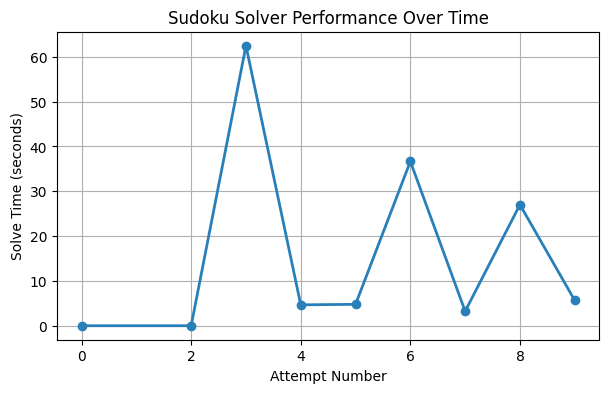

In [3]:
import tkinter as tk
from tkinter import messagebox
import time
import csv
import os
import matplotlib.pyplot as plt

# --- Sudoku Solver Logic (Backtracking + Visualization) ---
def is_valid(board, row, col, num):
    if num in board[row]:
        return False
    for r in range(9):
        if board[r][col] == num:
            return False
    start_row, start_col = 3 * (row // 3), 3 * (col // 3)
    for r in range(start_row, start_row + 3):
        for c in range(start_col, start_col + 3):
            if board[r][c] == num:
                return False
    return True


# --- GUI Class ---
class SudokuGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("Sudoku Solver")
        self.root.configure(bg="#f4f6f7")

        self.entries = [[None for _ in range(9)] for _ in range(9)]
        self.make_grid()
        self.figure, self.ax = None, None  # for persistent graph

        # Buttons
        btn_frame = tk.Frame(self.root, bg="#f4f6f7")
        btn_frame.pack(pady=10)

        tk.Button(btn_frame, text="Solve", command=self.solve_gui,
                  font=("Arial", 12), bg="#27ae60", fg="white", width=10).grid(row=0, column=0, padx=5)
        tk.Button(btn_frame, text="Clear", command=self.clear_grid,
                  font=("Arial", 12), bg="#c0392b", fg="white", width=10).grid(row=0, column=1, padx=5)
        tk.Button(btn_frame, text="Check Valid", command=self.check_valid_gui,
                  font=("Arial", 12), bg="#2980b9", fg="white", width=12).grid(row=0, column=2, padx=5)

    # --- Validation: allow only digits 1-9 or empty ---
    def validate_input(self, value):
        if value == "":
            return True
        if value.isdigit() and 1 <= int(value) <= 9:
            return True
        return False

    def make_grid(self):
        frame = tk.Frame(self.root, bg="#2c3e50")
        frame.pack(pady=10)

        vcmd = (self.root.register(self.validate_input), "%P")

        for row in range(9):
            for col in range(9):
                entry = tk.Entry(
                    frame, width=3, font=("Arial", 18), justify="center",
                    bg="white", relief="ridge", validate="key", validatecommand=vcmd
                )
                entry.grid(
                    row=row, column=col,
                    padx=(1 if col % 3 else 4),
                    pady=(1 if row % 3 else 4),
                    ipady=8
                )
                self.entries[row][col] = entry

    def get_board(self):
        board = []
        for row in range(9):
            current_row = []
            for col in range(9):
                val = self.entries[row][col].get()
                current_row.append(int(val) if val.isdigit() else 0)
            board.append(current_row)
        return board

    def fill_board(self, board):
        for row in range(9):
            for col in range(9):
                val = board[row][col]
                self.entries[row][col].delete(0, tk.END)
                if val != 0:
                    self.entries[row][col].insert(0, str(val))

    # --- Visual Backtracking Solve ---
    def solve_with_visual(self, board):
        for row in range(9):
            for col in range(9):
                if board[row][col] == 0:
                    for num in range(1, 10):
                        if is_valid(board, row, col, num):
                            board[row][col] = num
                            # Visualize the step
                            self.entries[row][col].delete(0, tk.END)
                            self.entries[row][col].insert(0, str(num))
                            self.entries[row][col].config(bg="#a8e6cf")
                            self.root.update()
                            time.sleep(0.02)  # delay for visualization

                            if self.solve_with_visual(board):
                                return True

                            # Backtrack visual
                            board[row][col] = 0
                            self.entries[row][col].delete(0, tk.END)
                            self.entries[row][col].config(bg="#ffaaa5")
                            self.root.update()
                            time.sleep(0.02)
                    return False
        return True

    def solve_gui(self):
        board = self.get_board()
        start_time = time.time()

        if self.solve_with_visual(board):
            end_time = time.time()
            solve_time = round(end_time - start_time, 4)
            self.fill_board(board)
            messagebox.showinfo("Success", f"Solved visually in {solve_time} seconds!")

            # Log + plot
            self.log_time(solve_time)
            self.plot_times()
        else:
            messagebox.showerror("Error", "No solution exists for this puzzle!")

    def clear_grid(self):
        for row in range(9):
            for col in range(9):
                e = self.entries[row][col]
                e.delete(0, tk.END)
                e.config(bg="white")

    def check_valid_gui(self):
        board = self.get_board()
        for row in range(9):
            for col in range(9):
                num = board[row][col]
                if num != 0:
                    board[row][col] = 0
                    if not is_valid(board, row, col, num):
                        messagebox.showwarning("Invalid", f"Invalid number {num} at row {row+1}, col {col+1}")
                        return
                    board[row][col] = num
        messagebox.showinfo("Valid", "Current board is valid!")

    # --- CSV Logging ---
    def log_time(self, solve_time):
        filename = "sudoku_times.csv"
        file_exists = os.path.exists(filename)
        with open(filename, "a", newline="") as f:
            writer = csv.writer(f)
            if not file_exists:
                writer.writerow(["Attempt", "Time(s)"])
            attempt = self.get_next_attempt_number(filename)
            writer.writerow([attempt, solve_time])

    def get_next_attempt_number(self, filename):
        if not os.path.exists(filename):
            return 1
        with open(filename, "r") as f:
            lines = f.readlines()
            return len(lines)

    # --- Persistent Plot ---
    def plot_times(self):
        filename = "sudoku_times.csv"
        if not os.path.exists(filename):
            return

        attempts, times = [], []
        with open(filename, "r") as f:
            reader = csv.DictReader(f)
            for row in reader:
                attempts.append(int(row["Attempt"]))
                times.append(float(row["Time (seconds)"]))

        if self.figure is None or self.ax is None:
            self.figure, self.ax = plt.subplots(figsize=(7, 4))
            plt.ion()  # interactive mode on

        self.ax.clear()
        self.ax.plot(attempts, times, marker='o', color="#2980b9", linewidth=2)
        self.ax.set_title("Sudoku Solver Performance Over Time")
        self.ax.set_xlabel("Attempt Number")
        self.ax.set_ylabel("Solve Time (seconds)")
        self.ax.grid(True)

        self.figure.canvas.draw()
        self.figure.canvas.flush_events()
        plt.pause(0.1)  # updates live plot


# --- Main Run ---
if __name__ == "__main__":
    root = tk.Tk()
    SudokuGUI(root)
    root.mainloop()